In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import statsmodels.api as sm
import matplotlib.pyplot as plt

/Users/cwx/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
discountVec = np.array(pd.read_excel("Homework_7_Data.xlsx", sheet_name="Discount Function", header=None).values.flatten())
volVec = np.array(pd.read_excel("Homework_7_Data.xlsx", sheet_name="Volatilities (Sigma)", header=None)[0].values.flatten())
choleskyMatrix = np.array(pd.read_excel("Homework_7_Data.xlsx", sheet_name="Cholesky Matrix", header=None))

1. The objective of this homework exercise is to implement the curve model described
in class where the risk-neutral dynamics of zero-coupon bonds are given by
$dB(t, T_i) = rB(t, T_i)dt + \sigma(T_i − t)B(t, T_i)dZ_i$
where each bond is driven by its own Brownian motion process.


2. The accompanying spreadsheet has the data for the case. The first sheet has the
20 × 20 matrix of correlations among the first 20 zero-coupon bond prices (ignore
the first zero-coupon bond price which is assumed to be non-stochastic). The second
sheet has the Cholesky decomposition of the correlation matrix. The third sheet has
the zero-coupon bond prices (the B(T) function). The fourth sheet has the volatility
function (the vector of σ values).

3. Following the methodology discussed in class, simulate the evolution of the vector
of zero-coupon prices out to 10 years. Ideally, one would want to simulate several
thousand paths of the vector of zero-coupon bond prices. We will leave it to you
to decide how many paths of the evolution of the zero-coupon bond price vector to
simulate.

In [3]:
class MonteCarlo:
    def __init__(self, _discountVec, _volVec, _choleskyMatrix, _num_simulations):
        self.disc = _discountVec
        self.vol = _volVec
        self.cholesky = _choleskyMatrix
        self.num = _num_simulations
    
    def generate_r(self):
        dz = self.cholesky @ np.random.normal(0,1,(20,20))
        b_arr = np.zeros((20,21))
        r_arr = np.zeros(20)
        b_arr[:,0] = self.disc
        for i in range(0,20):
            vol_arr = np.zeros(20)
            vol_arr[i:] = self.vol[:20-i]
            r = (1/b_arr[i,i]-1)*2
            b_arr[:,i+1] = b_arr[:,i]+r*b_arr[:,i]/2+vol_arr*b_arr[:,i]*dz[:,i]
            r_arr[i] = r
        return r_arr
    
    def get_sim(self):
        r_sim = np.zeros((20,self.num))
        for i in range(self.num):
            np.random.seed(i)
            r_sim[:,i] = self.generate_r()
        disc_sim = (1/(1+r_sim/2)).cumprod(axis=0)
        return r_sim,disc_sim
    


In [4]:
model = MonteCarlo(discountVec,volVec,choleskyMatrix,10000)
r_sim, disc_sim = model.get_sim()

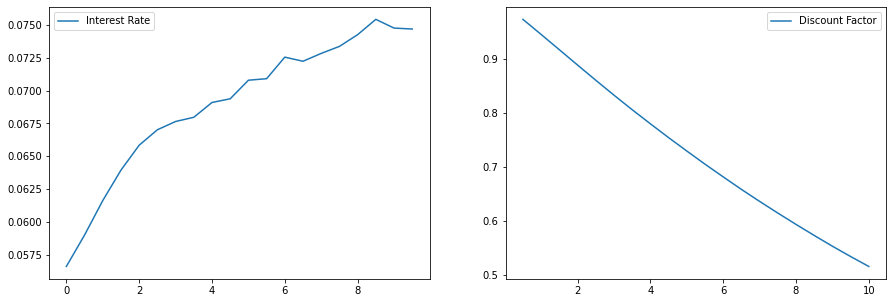

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, 10, 0.5),r_sim.mean(axis=1),label='Interest Rate')
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(0.5, 10.5, 0.5),disc_sim.mean(axis=1),label='Discount Factor')
plt.legend()
plt.show()

4. Using the initial B(T) function given in the spreadsheet, solve for the 2-year,
3-year, 5-year, and 10-year par rates.


In [6]:
times = [2, 3, 5, 10]
num = 10000
par_rates = np.zeros(len(times))
par_rates_sim = np.zeros(len(times))

def par_rate(maturity, _discountVec):
    return 2 * (1 - _discountVec[maturity*2-1])/sum(_discountVec[:maturity*2])

for time in times:
    par_rates[times.index(time)] = par_rate(time, discountVec)
    par_rates_sim[times.index(time)] = np.mean([par_rate(time,disc_sim[:,i]) for i in range(num)])

print('Actual:',par_rates)
print('Simulation:', par_rates_sim)

Actual: [0.0602296  0.0620556  0.06398321 0.06669473]
Simulation: [0.06015055 0.06201866 0.06417367 0.06732128]


5. Use the model to find the values of 2-year, 3-year, 5-year, and 10-year caps on Lt,
where Lt denotes the six-month rate at time t implied by the six-month zero-coupon
bond price B(t, t + 0.50). Set the strike rate of each cap to the par rate identified in
the previous question. For simplicity, assume that caplets are semiannual rather than
quarterly. Recall that the first caplet is omitted because of the setting in advance
feature.

In [7]:
cap = np.zeros(len(times))

def cap_price(K,r,disc):
    cf = (r-K)*0.5
    cf = np.where(cf < 0, 0, cf)
    return (cf*disc).sum(axis=0).mean()

for i in range(len(times)):
    cap[i] = cap_price(par_rates[i],r_sim,disc_sim)

cap

array([0.12892194, 0.12215669, 0.11537063, 0.10641647])

6. Value a 5-year resettable cap with a strike of 0.07 and semiannual caplets. The
cashflows from each caplet are $0.50 \cdot max(0, L_{0.5} − L_{0.0}), 0.50 \cdot max(0, L_{1.0} − L_{0.50})$, etc.
where Lt denotes the six-month rate at time t implied by the six-month zero-coupon
bond price B(t, t + 0.50).


In [8]:
def reset_cap_price(T,K,r,disc):
    cf = 0.5 * np.diff(r,axis=0)
    cf = np.where(cf<0,0,cf)
    cf2 = (r[T*2-1] - K)*0.5
    cf2 = np.where(cf2<0,0,cf2)
    return ((cf*disc[:-1])[:T*2].sum(axis=0)+cf2*disc[T*2-1]).mean()

reset_cap_price(5,0.07,r_sim,disc_sim)

0.04815411486370308

7. Value a 5-year CMS cap with a strike of 0.05 (semiannual caplets for simplicity).
The cash flow for the caplet expiring at time t + 0.50 is 0.50 $max(0, CMS_t − .05)$,
where CMSt denotes the 5-year par rate implied by the vector of zero-coupon bond
prices at time t. Note that the first caplet is omitted because of the setting in
advance feature.

In [9]:
def cms_cap_price(maturity,disc):
    cms = np.zeros((maturity*2,disc.shape[1]))
    for t in range(maturity*2):
        cms[t,:] = 2*(disc[t,:]-disc[t+maturity*2,:])/(disc[t:(t+maturity*2)]).sum(axis=0)
    cf = 0.5*(cms-0.05)
    cf = np.where(cf<0,0,cf)
    return (cf*disc[:5*2]).sum(axis=0).mean()

cms_cap_price(5,disc_sim)

0.08015274996819785